# What token embedding dimensionality does GPT-Neo need?

Experimenting with reducing GPT-Neo's token embedding dimensionality using SVD and measuring its resulting performance.

## Setup

In [1]:
DEVELOPMENT_MODE = False

In [2]:
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
    %pip install git+https://github.com/SamAdamDay/mechanistic-interpretability-projects.git
except:
    IN_COLAB = False
    print("Running as a Jupyter notebook - intended for development only!")
    from IPython import get_ipython

    ipython = get_ipython()
    # Code to automatically update the HookedTransformer code as its edited without restarting the kernel
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")

Running as a Jupyter notebook - intended for development only!
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/tmp/ipykernel_5066/2873378927.py:13: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("load_ext autoreload")
/tmp/ipykernel_5066/2873378927.py:14: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("autoreload 2")


In [3]:
import plotly.io as pio

if IN_COLAB or DEVELOPMENT_MODE:
    pio.renderers.default = "colab"
else:
    pio.renderers.default = "notebook_connected"
print(f"Using renderer: {pio.renderers.default}")


Using renderer: notebook_connected


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from sklearn.utils.extmath import randomized_svd

from datasets import load_dataset

import numpy as np

from fancy_einsum import einsum

from tqdm import tqdm

import plotly.express as px

import matplotlib.pyplot as plt

import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import (
    HookedTransformer,
    HookedTransformerConfig,
    FactoredMatrix,
    ActivationCache,
)


/root/mechanistic-interpretability-projects/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [5]:
torch.set_grad_enabled(False)

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## Reducing dimensionality

In [7]:
MAX_DIM = 200 #@param {type:"integer"}
BATCH_SIZE = 8 #@param {type:"integer"}
DATASET_SIZE = 1024 #@param {type:"integer"}

Load the model

In [8]:
model = HookedTransformer.from_pretrained("gpt-neo-125M", device=device)

Using pad_token, but it is not set yet.


Loaded pretrained model gpt-neo-125M into HookedTransformer


Get the token embedding lookup table

In [9]:
params = model.state_dict()
W_E = params["embed.W_E"]
print(W_E.shape)

torch.Size([50257, 768])


Compute the randomised SVD ( randomised because the matrix is really big)

In [10]:
W_E_numpy = utils.to_numpy(W_E)
U, S, Vh = randomized_svd(W_E_numpy, n_components=MAX_DIM)
US = U * S
print("US", US.shape)
print("Vh", Vh.shape)

US (50257, 200)
Vh (200, 768)


Load a dataset to evaluate the model performance

In [11]:
dataset = load_dataset("wikitext", "wikitext-2-v1", split="test")
dataset = dataset.filter(lambda data_dict: data_dict["text"] != "")
dataset = dataset.shuffle()[:DATASET_SIZE]
dataset_tokens = model.to_tokens(dataset["text"], move_to_device=False)

Found cached dataset wikitext (/root/.cache/huggingface/datasets/wikitext/wikitext-2-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126)
Loading cached processed dataset at /root/.cache/huggingface/datasets/wikitext/wikitext-2-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126/cache-a1a2501cebd05bee.arrow


Evaluate the model with the embedding lookup replaced with versions of reduced dimension

In [12]:
W_E_original = torch.clone(W_E)

dataloader = DataLoader(dataset_tokens, batch_size=BATCH_SIZE)

# Compute the average loss with the base model
total_loss = 0
for batch in tqdm(dataloader, f"Base model"):
    loss, _ = model.run_with_cache(batch, return_type="loss")
    total_loss += loss
base_loss = (total_loss / len(dataloader)).item()

loss_per_dim = np.zeros(MAX_DIM)

for i in range(MAX_DIM):

    # Replace the embedding lookup with the reduced dimension version
    W_E[:, :] = torch.tensor(US[:, :i+1] @ Vh[:i+1, :])

    # Compute the average loss
    total_loss = 0
    for batch in tqdm(dataloader, f"Dim [{i+1}/{MAX_DIM}]"):
        loss, _ = model.run_with_cache(batch, return_type="loss")
        total_loss += loss
    loss_per_dim[i] = (total_loss / len(dataloader)).item()

Dim [200/200]: 100%|██████████| 128/128 [00:08<00:00, 15.53it/s]


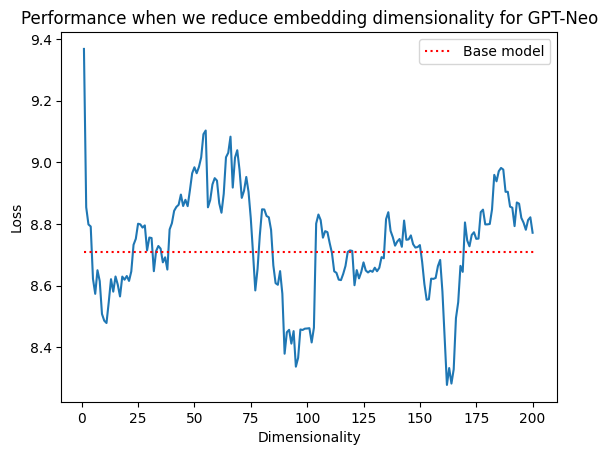

In [13]:
fig, ax = plt.subplots(1, 1)
ax.plot(np.arange(1, MAX_DIM + 1), loss_per_dim)
ax.plot([1, MAX_DIM+1], [base_loss, base_loss], "r:", label="Base model")
ax.set(
    title="Performance when we reduce embedding dimensionality for GPT-Neo",
    xlabel="Dimensionality",
    ylabel="Loss",
)
ax.legend()
plt.show()